In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
# load numpy array from npy file
from numpy import load
# load both electron and gamma files 
dset = load('files/electron_image.npy')
dset2 = load('files/gamma_image.npy')

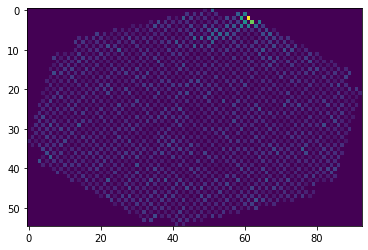

In [21]:
#plot a image
import matplotlib.pyplot as plt
plt.imshow(dset[1], interpolation='none',aspect='auto')
fig_size = plt.rcParams["figure.figsize"]
plt.show()

### split data

In [4]:
#put the target together
target0=np.zeros(dset.shape[0])
target1=np.ones(dset2.shape[0])
target=np.concatenate((target0, target1), axis=0)
#put the dataset together
data=np.concatenate((dset, dset2), axis=0)

In [5]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=2)  

In [6]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# input image dimensions
imgRows, imgCols = 55, 93
numChannels=1
samples=X_train.shape[0]
numClasses=2

#create x_train cause for CNN other shape is needed
x_train=X_train
x_test=X_test

#format: channels at the beginning
# x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
# x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
# input_shape = (1, img_rows, img_cols)

x_train = x_train.reshape(x_train.shape[0], imgRows, imgCols, 1)
x_test = x_test.reshape(x_test.shape[0], imgRows, imgCols, 1)
input_shape = (imgRows, imgCols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


Using TensorFlow backend.


## NN

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(numClasses, activation=tf.nn.softmax))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
%%time
model.fit(X_train, y_train, epochs=1, validation_data=(x_test, y_test)) #epochs es el numero de iteraciones hasta alcanzar un loss minimo

Train on 11771 samples, validate on 2943 samples
11771/11771 [==============================] - 4s 356us/sample - loss: 0.0647 - accuracy: 0.9753 - val_loss: 0.0180 - val_accuracy: 0.9969
Wall time: 4.57 s


In [9]:
val_loss, val_acc = model.evaluate(X_test, y_test)
# print(val_loss)
print(val_acc)
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

2943/2943 [==============================] - 0s 108us/sample - loss: 0.0180 - accuracy: 0.9969
0.9969419
[[ 535    4]
 [   5 2399]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       539
         1.0       1.00      1.00      1.00      2404

    accuracy                           1.00      2943
   macro avg       0.99      1.00      0.99      2943
weighted avg       1.00      1.00      1.00      2943



# build model

In [10]:
def create_model(stride=2,pool=2,filters=20,kernel=5,hidden_layers=1,neurons=128,optimizer='adam',
                 learn_rate=0.001, init_mode='glorot_uniform', activation='relu', dropout_rate=0.2,
                 weight_constraint=0):#parameters here are default

    #initialize the model
    model = Sequential()
    inputShape = (imgRows, imgCols,numChannels)                                                                        
    # define the first set of CONV => ACTIVATION => POOL layers
    model.add(Conv2D(filters, kernel, padding="same",input_shape=inputShape, activation=activation))
    model.add(MaxPooling2D(pool_size=(pool, pool), strides=(stride, stride)))  
    # define the second set of CONV => ACTIVATION => POOL layers
    model.add(Conv2D(int(round(filters*5/2)), kernel, padding="same", activation=activation))
    model.add(MaxPooling2D(pool_size=(pool, pool), strides=(stride, stride)))
    # define the first FC => ACTIVATION layers
    
    model.add(Flatten())
    for i in range(hidden_layers):
        model.add(Dense(neurons,kernel_initializer=init_mode,  activation=activation)) 
        model.add(keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))    #, use_bias=False
        model.add(Dropout(dropout_rate)) 
    # lastly, define the soft-max classifier
    model.add(Dense(numClasses, activation='softmax'))
  
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])              

    return model


In [11]:
shape=x_train.shape
model=create_model()
model.build(shape) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 55, 93, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 46, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 46, 50)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 23, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14950)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1913728   
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)              

In [12]:
%%time
model=create_model()
hist=model.fit(x_train, y_train, epochs=1,batch_size=128, validation_data=(x_test, y_test))

Train on 11771 samples, validate on 2943 samples
Epoch 1/1
11771/11771 [==============================] - 79s 7ms/step - loss: 0.0516 - accuracy: 0.9872 - val_loss: 0.1391 - val_accuracy: 0.9969
Wall time: 1min 20s


In [13]:
val_loss, val_acc = model.evaluate(x_test, y_test)
# print(val_loss)
print(val_acc)
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict_classes(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

2943/2943 [==============================] - 5s 2ms/step
0.9969419240951538
[[ 535    4]
 [   5 2399]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       539
         1.0       1.00      1.00      1.00      2404

    accuracy                           1.00      2943
   macro avg       0.99      1.00      0.99      2943
weighted avg       1.00      1.00      1.00      2943



# Results

In [14]:
class_names = [ 'electron','gamma']

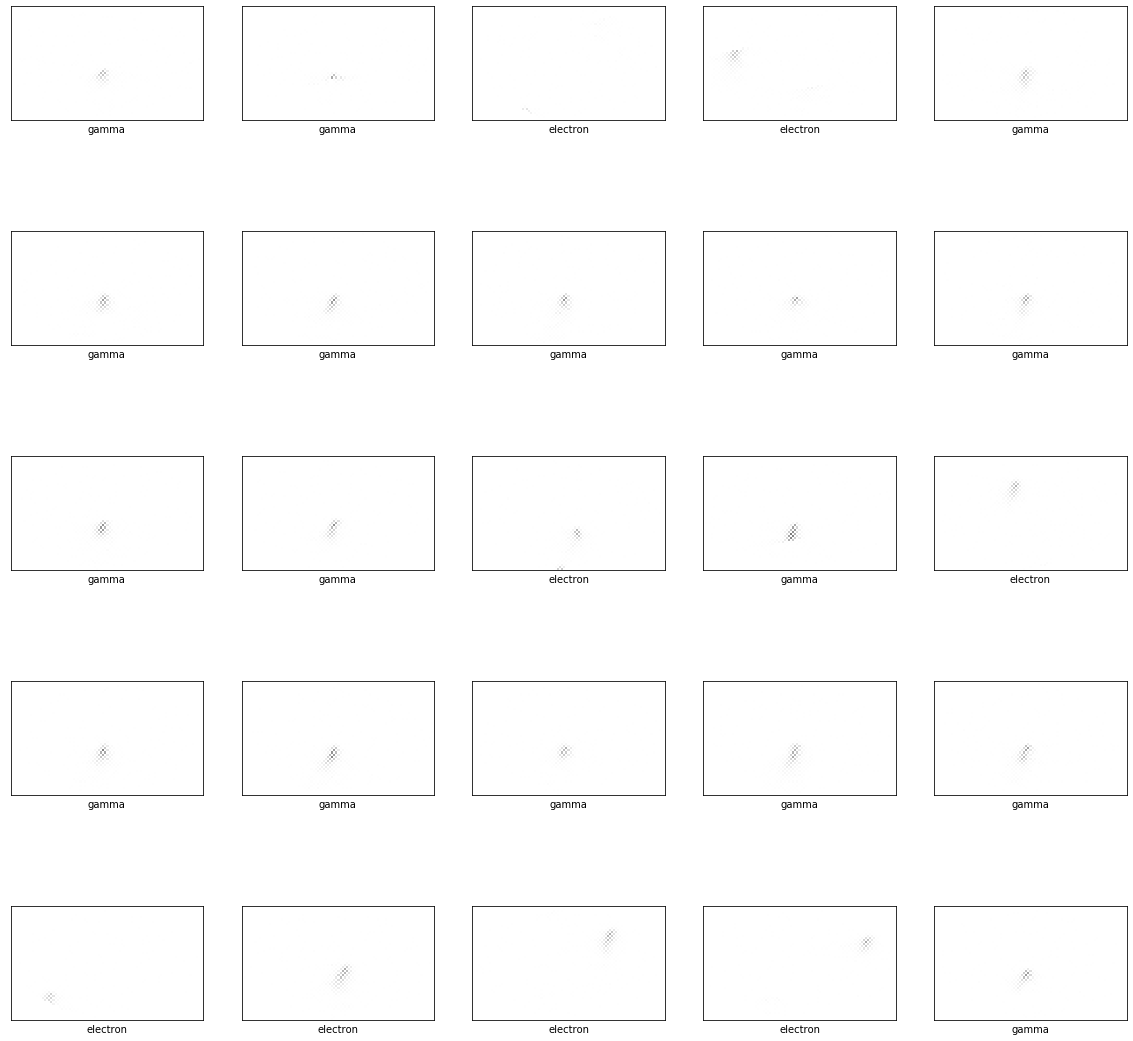

In [15]:
y_train=y_train.astype(int)
y_test=y_test.astype(int)
plt.figure(figsize=(20,20))
imagenes=25
for i in range(imagenes):
    plt.subplot(imagenes/5,imagenes/5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary, vmin=0, vmax=1)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [16]:
predictions = model.predict(x_test)
print(predictions[0])
np.argmax(predictions[0])

# predictions = model.predict_classes(x_test)
# predictions[0]

[0.16398536 0.8360147 ]


1

In [17]:
#define a function to create images that show classification

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)#, cmap=plt.cm.binary

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")#EN RANGE PONER NUMERO DE CLASES
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [18]:
# #plot one image
# i = 1
# plt.figure(figsize=(18,9))
# plt.subplot(1,2,1)
# plot_image(i, predictions[i], y_test, X_test)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i],  y_test)
# plt.show()

In [19]:
#For instance, here I can select bad  for a certain praticle

index1=np.where((y_test==0) & (y_pred!=y_test))[0]
index2=np.where((y_test==1)& (y_pred!=y_test))[0]
index=np.concatenate([index1,index2])
index=np.sort(index)
incorrect = np.where(y_pred!=y_test)[0]
correct = np.where(y_pred==y_test)[0]
len(incorrect) 

9

IndexError: index 9 is out of bounds for axis 0 with size 9

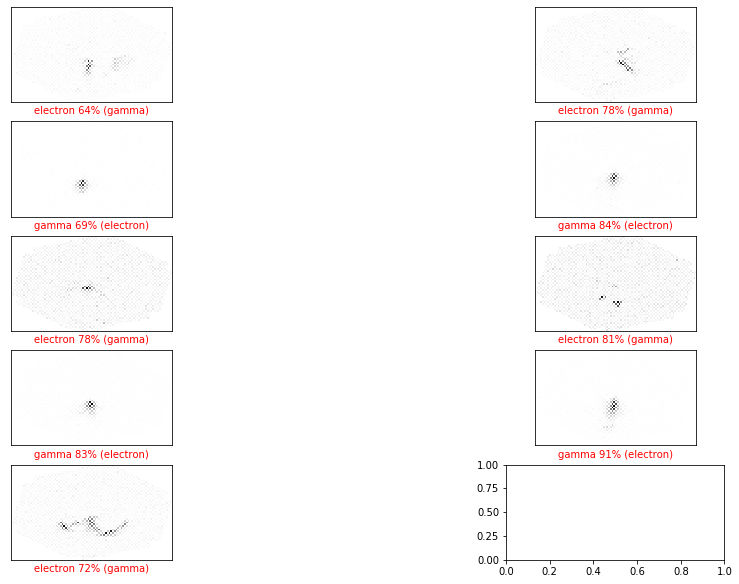

In [20]:
num_rows = 100
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols+10, 2*num_rows+10))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[incorrect][i], y_test[incorrect], X_test[incorrect])
#   plt.subplot(num_rows, 2*num_cols, 2*i+2)
#   plot_value_array(i, predictions[i],  y_test)
plt.tight_layout()
plt.show()